This notebook is about identifying stroke and swing for tennis sports.

We are using [Myoarm band](https://www.myo.com/) a wearble device to be worn on your fore arm. This device has accelerometer, gyroscope and magnetometer. Along with that it also has eight EMG(Electic Myo graphy) which measues the activity of the muscle, using this it can identify type of gesture created by hand.

We will be using Accelerometer and Gyroscope data to identify the stroke and swing.
Typically acceleremeter data will help us find type of swing played(Topspin, Slice, Serve, Flat .etc) and gyroscope with help us to find fore hand and back hand stroke.

Currently we are only considereing right handed player for the data collection and modelling, but this model should also work for the left handed player but the output/prediction would be totally opposite(Like forehand will be considered as a backhand).

Importing important libraries

In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Import data through pandas, 


In [2]:
path = "./data/"
file_name = path + "train_forehand_set1.csv"
data_file = pd.read_csv(file_name, sep=',',header=0);




In [3]:
data_file.head()

Unnamed: 0    timestamp  orientation_x  orientation_y  orientation_z  \
0           0  60197786821       0.081177      -0.451477       0.472595   
1           1  60197810516       0.090698      -0.462891       0.460205   
2           2  60197825695       0.099426      -0.473755       0.449402   
3           3  60197846974       0.109802      -0.480652       0.441101   
4           4  60197870619       0.119934      -0.485779       0.435364   

   orientation_w      AccX      AccY      AccZ    GyroX   GyroY    GyroZ  \
0       0.752502  0.937988 -0.213867  0.375000  -0.1250 -41.625 -57.3750   
1       0.752075  1.140140 -0.089355  0.113281 -20.3750 -43.625 -53.3750   
2       0.750732  1.205080 -0.137207  0.059570 -14.7500 -37.375 -45.0000   
3       0.749817  1.175290 -0.065430  0.071777   6.0000 -25.250 -39.6875   
4       0.748352  1.162110 -0.011719  0.074219  14.9375 -19.000 -26.5000   

       roll     pitch      yaw  
0 -0.484127 -0.857490  1.34635  
1 -0.480964 -0.894245  1.33229  
2 -0.479860 -0.928448  1.32250  
3 -0.467457 -0.957351  1.30926  
4 -0.453729 -0.981797  1.29930

In [4]:
time = data_file['timestamp'];
gyr = data_file[['GyroX', 'GyroY', 'GyroZ']];
acc = data_file[['AccX', 'AccY', 'AccZ']] ;
quaternion = data_file[['orientation_w', 'orientation_x', 'orientation_y', 'orientation_z']]
#euler = data_file[['roll', 'pitch', 'yaw']]




#Following code helps to identify strokes from a accelerometer data
#We use accelerometer data, and it is passed thru butter filter.
#we first normalize the accelerometer data, and then we pass it to remove highfrequency,

In [5]:
def identifyStroke(time, accleration,threshold =1, hpCutOff=.001, 
                   lpCutOff=5.0, sampleFrequecy = 50, number_of_pass = 1, axis=1, plot=True):
    acc_mag= np.sqrt(np.square(accleration).sum(axis=axis))
    b, a =  signal.butter(number_of_pass, 
                          (2*hpCutOff) / sampleFrequecy, 'high', 
                          analog=False)
    
    hp_filt = signal.filtfilt(b, a, acc_mag)
    hp_filt = np.absolute(hp_filt); 
    b, a = signal.butter(number_of_pass, ((2*lpCutOff)/sampleFrequecy), 'low')
    lp_filt = signal.filtfilt(b, a, hp_filt)
    stationary = lp_filt > threshold;
    
    if(plot):
        f, (ax1,  ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(18,20))
        ax1.plot(time, accleration,)
        ax1.legend(['X','Y','Z'],shadow=True, fancybox=True, loc="upper right");
        
        ax2.plot(time, acc_mag, 'r', label="Magnitude(sqrt(x2+y2+z2))");
        ax2.legend(shadow=True, fancybox=True, loc="upper right");
        
        ax3.plot(time, hp_filt, 'b', label="High Pass Filtered");
        ax3.legend(shadow=True, fancybox=True, loc="upper right");
        
        ax4.plot(time, lp_filt, 'r', label="Low Pass Filtered");
        ax4.plot(time, stationary, 'b', label="Swing");
        ax4.legend(shadow=True, fancybox=True, loc="upper right");
        
    return stationary



def strokeIndexes(time, accleration):
    swingPresent = identifyStroke(time, accleration)
    swing_diff = np.diff(swingPresent+0)
    swingStartIndex = np.where(swing_diff == 1)[0]
    swingEndIndex = np.where(swing_diff == -1)[0]
    swingMidIndex = swingStartIndex + swingEndIndex
    swingMidIndex = np.divide(swingMidIndex,2)
    
    return  swingMidIndex,  swingStartIndex, swingEndIndex, swingPresent


In [6]:

def plotSwingData(time, gyr, acc, quat, swingPresent, startPos, endPos):
    fig = plt.figure('Position', figsize=(18,10));
    fig.subplots_adjust(hspace=.7)

    plt.subplot(411);
    plt.plot(time[startPos:endPos], gyr[startPos:endPos]);
    #plt.plot(time[startPos:endPos], swingPresent[startPos:endPos], ':m');
    plt.title('Gyroscope');
    plt.xlabel('Time (s)');
    plt.ylabel('Angular velocity (^\circ/s)');
    plt.legend(list(gyr),shadow=True, fancybox=True, loc="upper right");


    plt.subplot(412);
    plt.plot(time[startPos:endPos], acc[startPos:endPos]);
    plt.plot(time[startPos:endPos], swingPresent[startPos:endPos], ':m');
    plt.title('Accelerometer');
    plt.xlabel('Time (s)');
    plt.ylabel('Acceleration (g)');
    plt.legend(list(acc), shadow=True, fancybox=True, loc="upper right");


    plt.subplot(413);
    plt.plot(time[startPos:endPos], quat[startPos:endPos]);
    plt.plot(time[startPos:endPos], swingPresent[startPos:endPos], ':m',);
    plt.title('Quaternions');
    plt.xlabel('Time (s)');
    plt.ylabel('Quaternions');
    plt.legend(list(quaternion), shadow=True, fancybox=True, loc="upper right");



In [7]:
def quaternProd(a, b):
    ab = np.zeros(a.shape);
    w, x, y, z = 0, 1, 2, 3
    ab[:,w] = a[:,w]*b[:,w] - a[:,x]*b[:,x] - a[:,y]*b[:,y] - a[:,z]*b[:,z];
    ab[:,x] = a[:,w]*b[:,x] + a[:,x]*b[:,w] + a[:,y]*b[:,z] - a[:,z]*b[:,y];
    ab[:,y] = a[:,w]*b[:,y] - a[:,x]*b[:,z] + a[:,y]*b[:,w] + a[:,z]*b[:,x];
    ab[:,z] = a[:,w]*b[:,z] + a[:,x]*b[:,y] - a[:,y]*b[:,x] + a[:,z]*b[:,w];
    return ab;

def quaternConj(q):
    ab = np.zeros(q.shape);
    w, x, y, z = 0, 1, 2, 3
    ab[:,w] = q[:,w]
    ab[:,x] = -q[:,x]
    ab[:,y] = -q[:,y]
    ab[:,z] = -q[:,z]
    return ab

def quaternRotate(v, q):
    (row, col) = v.shape;
    quaterPoint = np.append(np.zeros((row,1)), v, 1)
    #v0XYZ = quaternProd(quaternProd(q, acc), quaternConj(q));
    v0XYZ = quaternProd(q, quaternProd(quaterPoint, quaternConj(q))); 
    return v0XYZ[:, 1:4];

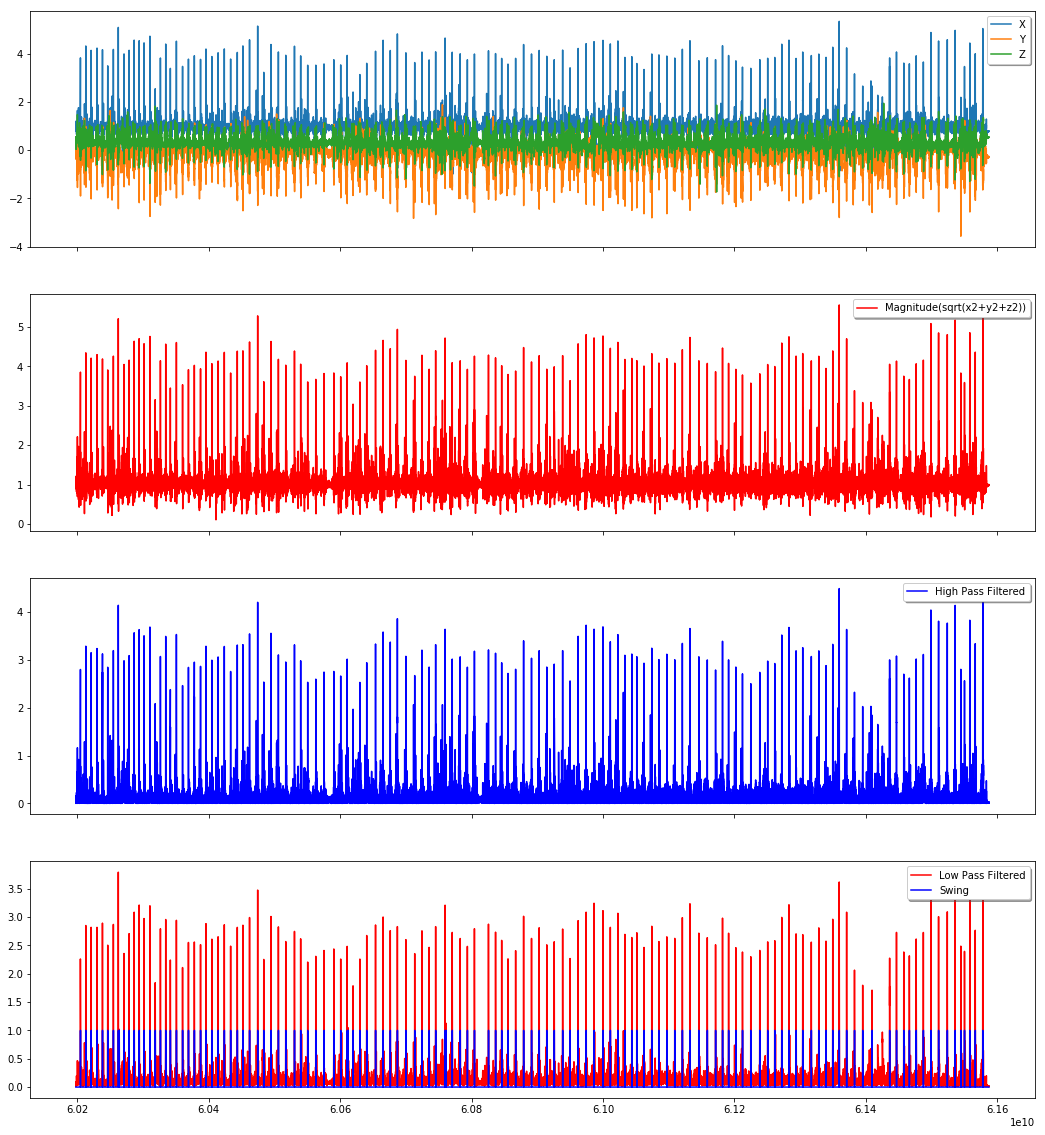

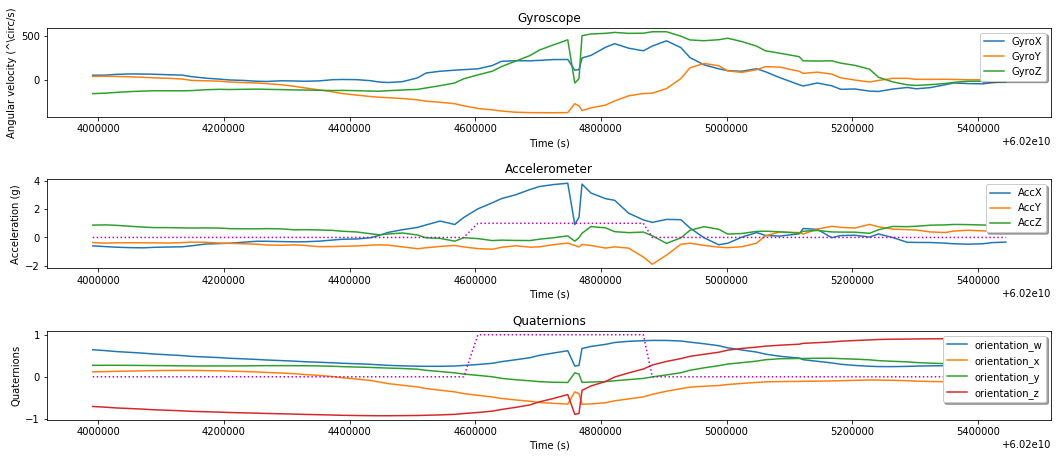

In [8]:

swingMidIndex, swingStartIndex, swingEndIndex, swingPresent = strokeIndexes(time, acc)

startPos = swingStartIndex[0] - 30
endPos = swingEndIndex[0] + 30


plotSwingData(time, gyr, acc, quaternion, swingPresent, startPos, endPos )

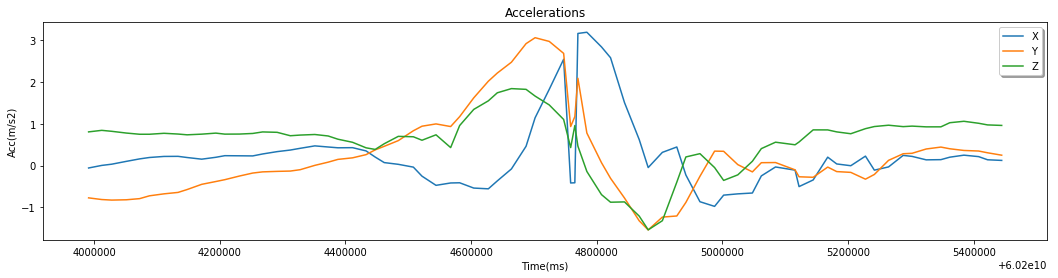

In [9]:
#Compute translational accelerations
def plot_findings(figName, x, y, xlabel, ylabel, legendlabel, figSize=(18,4)):
    plt.figure(figName, figsize=figSize);
    plt.plot(x, y)
    plt.title(figName);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.legend(legendlabel, shadow=True, fancybox=True, loc="upper right");

def cal_tran_acc(time, acc, quat, startPos, endPos,plot=True,):
    accelerometer = acc.copy()
    quat = quat.as_matrix()
    ##Rotate body accelerations to Earth frame
    accelerometer = quaternRotate( accelerometer, quaternConj(quat));
    if(plot):
        plot_findings("Accelerations", time[startPos:endPos], 
                      accelerometer[startPos:endPos], "Time(ms)", "Acc(m/s2)", ('X', 'Y', 'Z'))
    return accelerometer

translation_acc = cal_tran_acc(time, acc,quaternion, startPos, endPos)

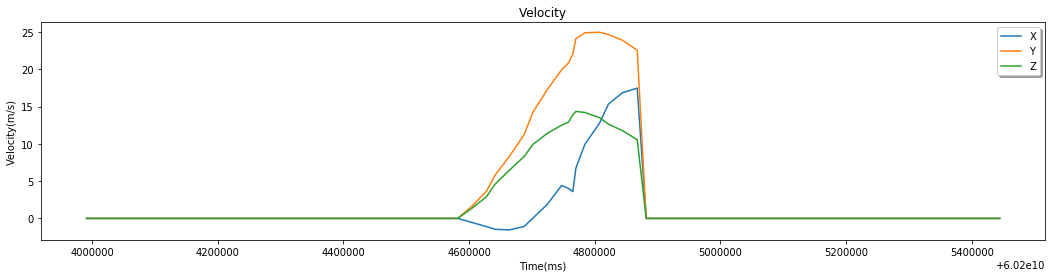

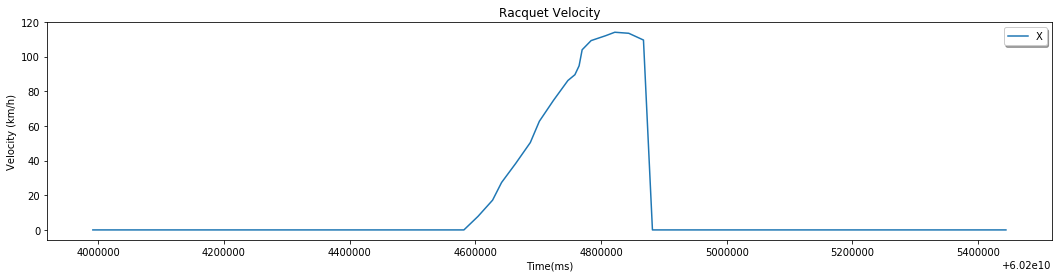

In [10]:
#removing earth's gravity(default ) from z axis

#acc[:,2] = acc[:,2] 9.81;
#samplePeriod = 50;

#Integrate acceleration to yield velocity
vel = np.zeros(translation_acc.shape);
for t in range(1,len(vel)):
    vel[t,:] = vel[t - 1,:] + translation_acc[t,:]# * samplePeriod;
    if(swingPresent[t] == 0):
        vel[t,:] = [0, 0, 0];     # force zero velocity when foot stationary
    
velDrift = np.zeros(vel.shape);
plot_findings("Velocity", time[startPos:endPos], 
                      vel[startPos:endPos], "Time(ms)", "Velocity(m/s)", ('X', 'Y', 'Z'))

velocity_norm =  np.linalg.norm(vel, axis=1)
plot_findings("Racquet Velocity", time[startPos:endPos], 
                      velocity_norm[startPos:endPos] * 3.6, "Time(ms)", 'Velocity (km/h)', ('X', 'Y', 'Z'))


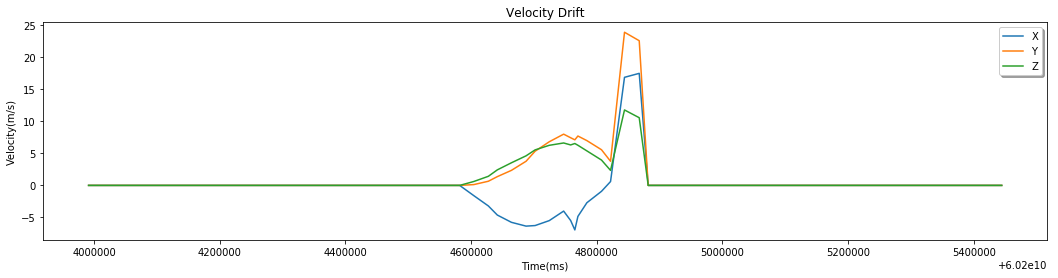

In [11]:

velDrift = np.zeros(vel.shape);
for i in range(0, len(swingEndIndex)):
    rateDiff = (swingEndIndex[i] - swingStartIndex[i])
    driftRate = np.divide(vel[swingEndIndex[i] - 1, :], rateDiff)
    enum = np.arange(0, (swingEndIndex[i] - swingStartIndex[i])-1);
    enum = np.array([enum, enum, enum])
    drift = enum.T * driftRate
    velDrift[swingStartIndex[i]:swingEndIndex[i]-1, :] = drift;

vel = vel - velDrift;             
plot_findings("Velocity Drift", time[startPos:endPos], 
                      vel[startPos:endPos], "Time(ms)", "Velocity(m/s)", ('X', 'Y', 'Z'))


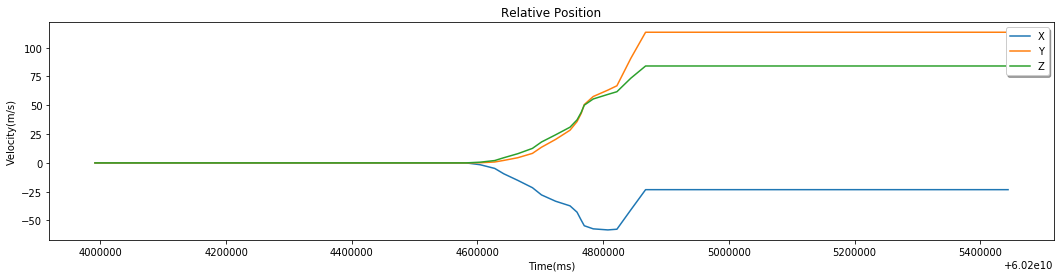

In [12]:
# Compute translational position
# Integrate velocity to yield position


pos = np.zeros(vel.shape);
for t in range(2, len(pos)):
    pos[t] = pos[t-1] + vel[t];    # integrate velocity to yield position
            
plot_findings("Relative Position", time[startPos:endPos], 
                      pos[startPos:endPos], "Time(ms)", "Velocity(m/s)", ('X', 'Y', 'Z'))


0.0


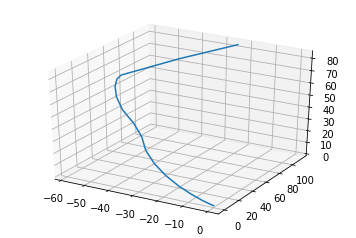

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation


fig = plt.figure()
print pos[6,0]
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos[300:400,0],pos[300:400,1],pos[300:400, 2])

plt.show()

(5240, 10, 50)
(5000, 10, 50)


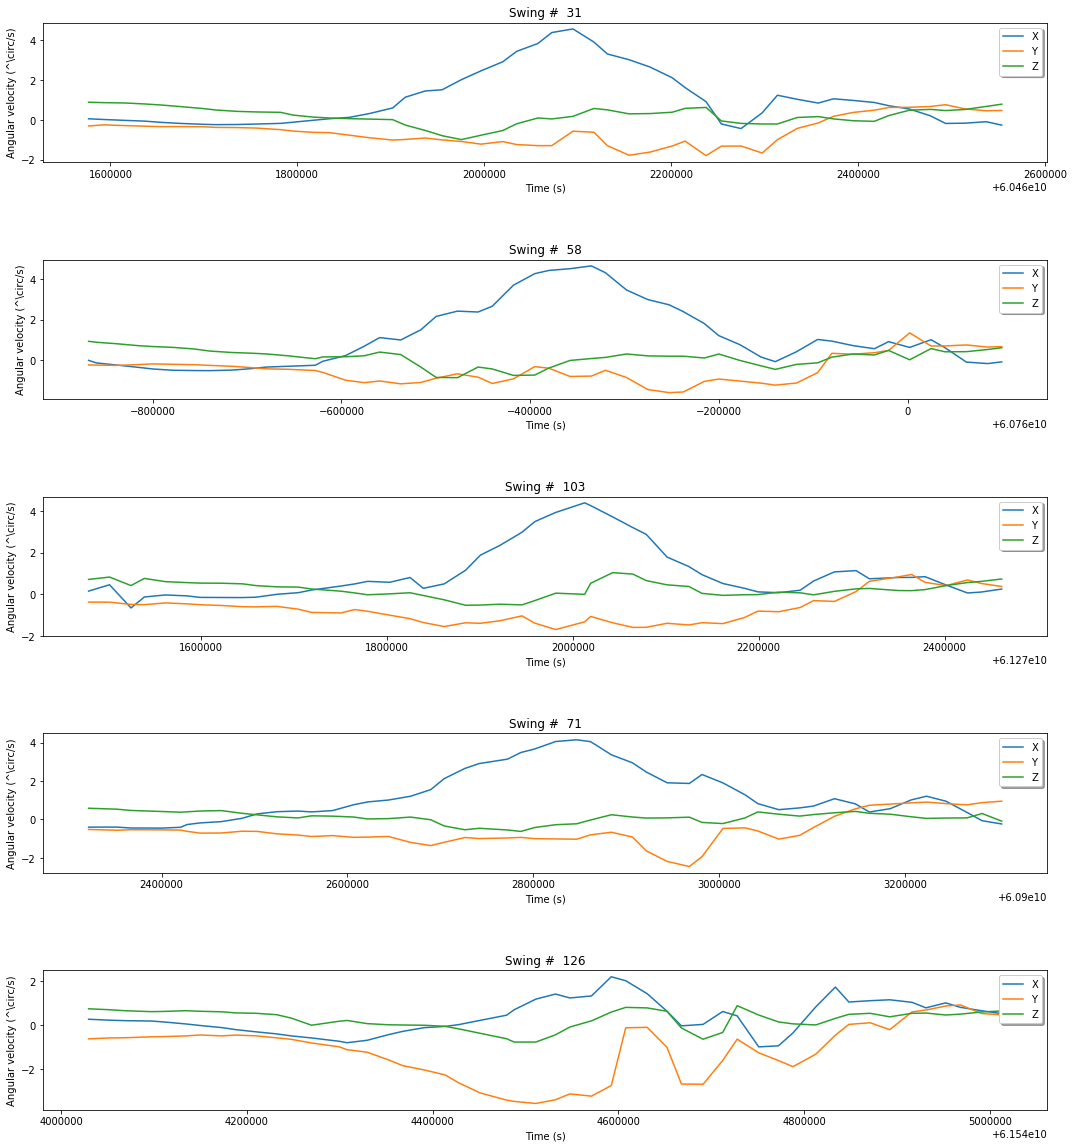

In [14]:
##to do use rolling window to augment data
sample_size = 5;

##to do random sample of 8 swings
sample_index = np.random.randint(0, swingMidIndex.shape[0], size=sample_size)
f, axes = plt.subplots(sample_size,  figsize=(18,20))
f.subplots_adjust(hspace=.7)
i = 0;
for index in sample_index: 
    si = swingMidIndex[index]
    axes[i].plot()
    axes[i].plot(time[si-25:si+25],acc[si-25:si+25] )
    axes[i].set_title('Swing #  %d' % index);
    axes[i].set_xlabel('Time (s)');
    axes[i].set_ylabel('Angular velocity (^\circ/s)');
    axes[i].legend(['X', 'Y', 'Z'],shadow=True, fancybox=True, loc="upper right");
    i += 1

s = []
a = acc[si-25:si+25].as_matrix().T
b = gyr[si-25:si+25].as_matrix().T
z = quaternion[si-25:si+25].as_matrix().T
np.concatenate((a,b), axis=1)
def swingDataAugmenation(swingMidIndex, Y_value):
    x_features, y_label = [], []
    # for each swing generate 50, 3 matrix by sliding 15 data points before and 15 data points after
    #this will give us 30 swings in total each swing. 
    for index in swingMidIndex: 
        for i in range(20):
            a = acc.iloc[index-25-i:index+25-i].as_matrix().T
            g = gyr.iloc[index-25-i:index+25-i].as_matrix().T
            q = quaternion.iloc[index-25-i:index+25-i].as_matrix().T
            
            a = np.concatenate((a,g), axis=0)
            a = np.concatenate((a,q), axis=0)
            x_features.append(a)
            y_label.append(Y_value)
            a = acc.iloc[index-25+i:index+25+i].as_matrix().T
            g = gyr.iloc[index-25+i:index+25+i].as_matrix().T
            q = quaternion.iloc[index-25+i:index+25+i].as_matrix().T
            a = np.concatenate((a,g), axis=0)
            a = np.concatenate((a,q), axis=0)
            x_features.append(a)
            y_label.append(Y_value)
    return np.array(x_features), np.array(y_label)

        
def noSwingDataAugmenation(swingMidIndex, Y_value, sample_size=5000):
    x_features, y_label = [], []
    for i in range(0, swingMidIndex.shape[0]-1):
        startIndex = swingMidIndex[i] + 70;
        endIndex = swingMidIndex[i+1] - 70;
        
        while(startIndex<endIndex and endIndex-startIndex > 50):
            a = acc.iloc[startIndex:startIndex + 50].as_matrix().T
            g = gyr.iloc[startIndex:startIndex + 50].as_matrix().T
            q = quaternion.iloc[startIndex:startIndex + 50].as_matrix().T
            
            a = np.concatenate((a,g), axis=0)
            a = np.concatenate((a,q), axis=0)
            x_features.append(a)
            y_label.append(Y_value)
            startIndex += 2;
            if(len(x_features) == sample_size):
                return np.array(x_features), np.array(y_label)
    
    return np.array(x_features), np.array(y_label)

trueSwing_X, trueSwing_Y = swingDataAugmenation(swingMidIndex, 1)
print(trueSwing_X.shape)
falseSwing_X, falseSwing_y = noSwingDataAugmenation(swingMidIndex, 0)
print(falseSwing_X.shape)
swingDataSet_X = np.concatenate((trueSwing_X, falseSwing_X))
swingDataSet_Y = np.concatenate((trueSwing_Y, falseSwing_y))
    
        


In [15]:
s = []
a = acc[si-25:si+25].as_matrix().T
b = gyr[si-25:si+25].as_matrix().T
z = quaternion[si-25:si+25].as_matrix().T
m = np.concatenate((a,b), axis=0)
m = np.concatenate((m,z), axis=0)
m.shape

(10, 50)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(swingDataSet_X, 
                                        swingDataSet_Y, test_size=0.3, 
                                        random_state=1, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                    test_size=0.5, random_state=1)

X_train = np.expand_dims(X_train,4)
X_val = np.expand_dims(X_val,4)
X_test = np.expand_dims(X_test, 4)

print (X_train.shape, X_val.shape, X_test.shape)

((7168, 10, 50, 1), (1536, 10, 50, 1), (1536, 10, 50, 1))


/Users/shafidayatar/anaconda/envs/python2.7-DA/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  if __name__ == '__main__':
/Users/shafidayatar/anaconda/envs/python2.7-DA/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  # Remove the CWD from sys.path while we load stuff.
/Users/shafidayatar/anaconda/envs/python2.7-DA/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  # This is added back by InteractiveShellApp.init_path()


In [17]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Conv1D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, LeakyReLU
from keras.models import Sequential
from keras.utils import plot_model

/Users/shafidayatar/anaconda/envs/python2.7-DA/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [56]:

model = Sequential()
model.add(Conv2D(16, 3, padding="same", activation='relu', input_shape=(10,50,1)))
model.add(Conv2D(32, 3, activation='relu'))
model.add(Dropout(.2))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Dropout(.2))
model.add(Conv2D(128, 3, activation='relu'))
model.add(Dropout(.4))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(1, activation='sigmoid', kernel_initializer='truncated_normal'))

model.summary()
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 10, 50, 16)        160       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 48, 32)         4640      
_________________________________________________________________
dropout_17 (Dropout)         (None, 8, 48, 32)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 6, 46, 64)         18496     
_________________________________________________________________
dropout_18 (Dropout)         (None, 6, 46, 64)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 4, 44, 128)        73856     
_________________________________________________________________
dropout_19 (Dropout)         (None, 4, 44, 128)        0         
__________

In [58]:
 #X_train, X_test, y_train, y_test
#X_train = X_train.expand_dims(n=4)
trained = model.fit(X_train, y_train, epochs=4, batch_size=30, validation_data=(X_val, y_val),verbose=1)

Train on 7168 samples, validate on 1536 samples
Epoch 1/4
7168/7168 [==============================] - 30s 4ms/step - loss: 0.0035 - acc: 0.9983 - val_loss: 0.0064 - val_acc: 0.9974
Epoch 2/4
7168/7168 [==============================] - 30s 4ms/step - loss: 0.0019 - acc: 0.9989 - val_loss: 0.0048 - val_acc: 0.9987
Epoch 3/4
7168/7168 [==============================] - 29s 4ms/step - loss: 0.0033 - acc: 0.9982 - val_loss: 0.0019 - val_acc: 0.9987
Epoch 4/4
7168/7168 [==============================] - 29s 4ms/step - loss: 0.0035 - acc: 0.9980 - val_loss: 0.0247 - val_acc: 0.9961


['acc', 'loss', 'val_acc', 'val_loss']


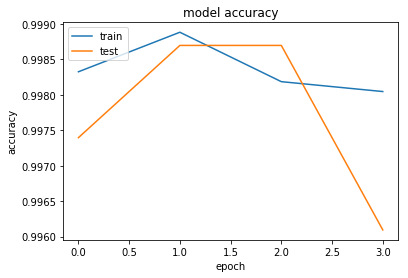

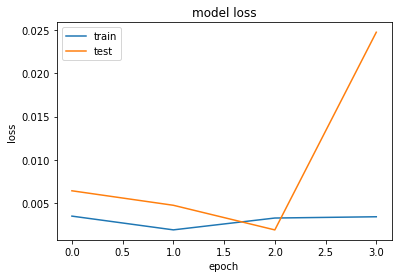

In [59]:
# list all data in history
print(trained.history.keys())
# summarize history for accuracy
plt.plot(trained.history['acc'])
plt.plot(trained.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
#
model_prediction = [model.predict(np.expand_dims(test_vector, 0)) for test_vector in X_test]
model_prediction = np.array(model_prediction)
model_prediction[np.where(model_prediction>=.5)] = 1
model_prediction[np.where(model_prediction<.5)] = 0
model_prediction= model_prediction.flatten()
model_prediction = model_prediction.astype(int)
test_accuracy = 100*np.sum(model_prediction==y_test)/len(model_prediction)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 99.0000%


In [53]:
file_name = "data/" + "train_backhand_topspin_set1.csv"
test_file = pd.read_csv(file_name, sep=',',header=0);
#test_file.head()
test_time = test_file['timestamp']
test_acc = test_file[['AccX','AccY', 'AccZ']]
test_gyr = test_file[['GyroX', 'GyroY', 'GyroZ']]
test_quat = test_file[['orientation_w', 'orientation_x', 'orientation_y', 'orientation_z']]
print test_acc.shape
swing_test = []
for i in range(0, test_acc.shape[0]-50, 50):
    a = test_acc[i:i+50].as_matrix().T
    g = test_gyr[i:i+50].as_matrix().T
    q = test_quat[i:i+50].as_matrix().T
            
    a = np.concatenate((a,g), axis=0)
    a = np.concatenate((a,q), axis=0)
    
    swing_test.append(a)

swing_test = np.array(swing_test)

print swing_test.shape
swing_test = np.expand_dims(swing_test,4)
print swing_test.shape  


(42974, 3)
(859, 10, 50)
(859, 10, 50, 1)


/Users/shafidayatar/anaconda/envs/python2.7-DA/lib/python2.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [54]:
model_prediction = [model.predict(np.expand_dims(test_vector, 0)) for test_vector in swing_test]
model_prediction = np.array(model_prediction)
model_prediction[np.where(model_prediction>=.5)] = 1
model_prediction[np.where(model_prediction<.5)] = 0
model_prediction= model_prediction.flatten()
model_prediction = model_prediction.astype(int)
test_accuracy = 100*np.sum(model_prediction==y_test)/len(model_prediction)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 0.0000%


/Users/shafidayatar/anaconda/envs/python2.7-DA/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  import sys


(859,)
37
[ 11  16  22  28  34  39  47  56  65  73  80  89  97 104 114 119 127 138
 145 151 161 177 184 191 197 204 211 228 243 254 270 277 291 301 312 320
 329 340 349 360 370 382 394 425 435 447 459 469 482 495 507 516 530 542
 555 563 572 583 592 601 609 615 622 628 634 641 649 660 669 676 683 691
 700 707 713 721 728 735 741 748 759 771 778 784 789 794 803 813 822 829
 836 843 848 854]


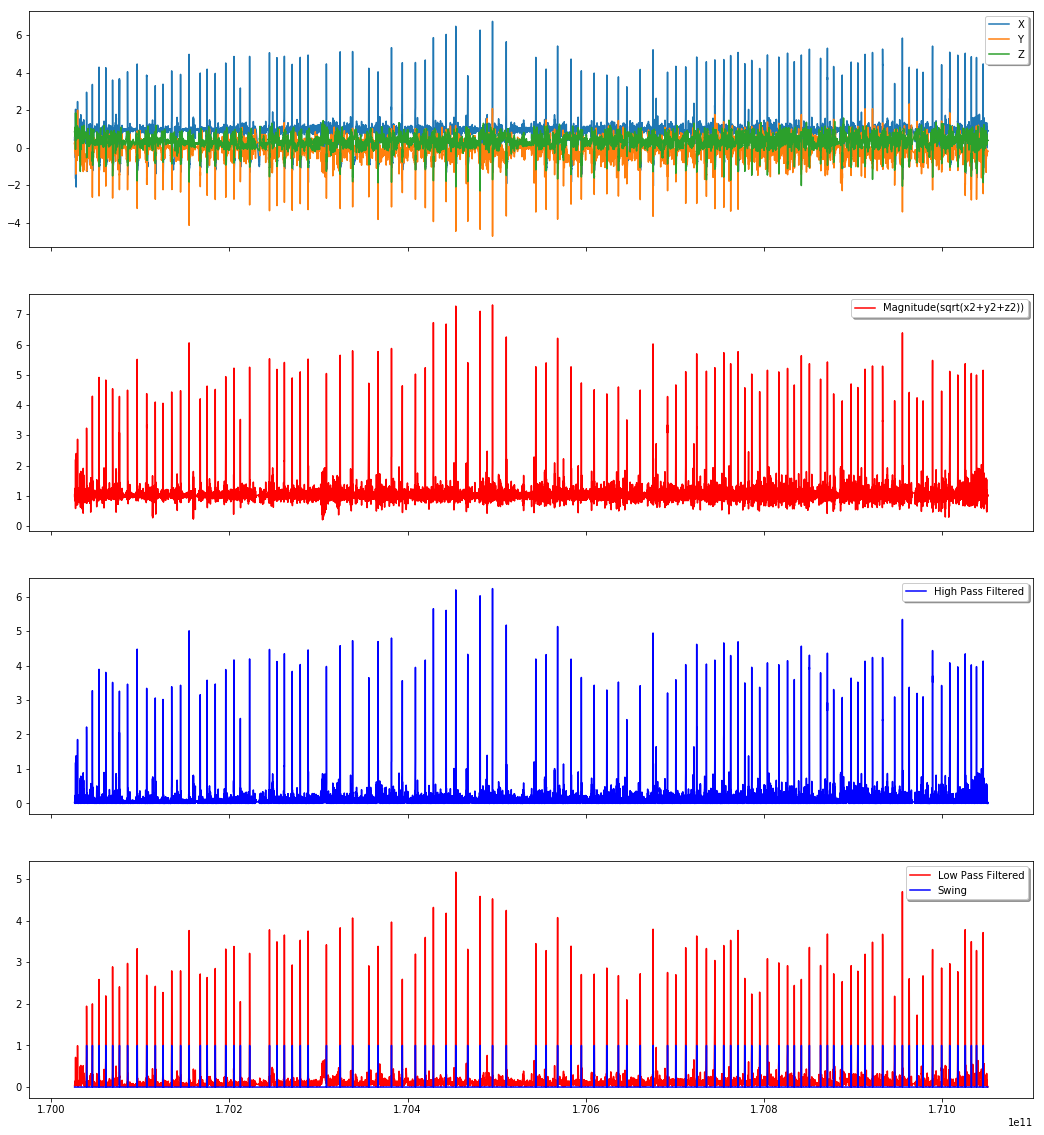

In [55]:
swingMidIndex, swingStartIndex, swingEndIndex, swingPresent = strokeIndexes(test_time, test_acc)


print model_prediction.shape
print len(np.where(model_prediction==1)[0])
print swingMidIndex / 50




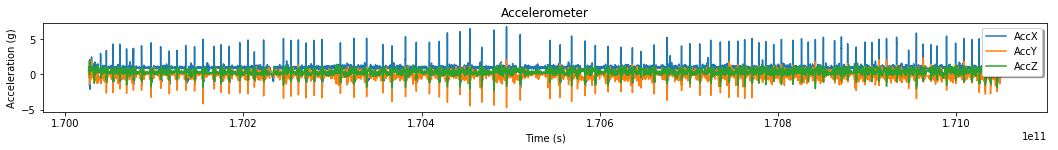

In [24]:
fig = plt.figure('Position', figsize=(18,10));
sample_time = test_file['timestamp']
fig.subplots_adjust(hspace=.7)
plt.subplot(411);
plt.plot(sample_time, test_acc);
#plt.plot(time, stationary, 'k', 'LineWidth', 2);
plt.title('Accelerometer');
plt.xlabel('Time (s)');
plt.ylabel('Acceleration (g)');
plt.legend(list(acc), shadow=True, fancybox=True, loc="upper right");



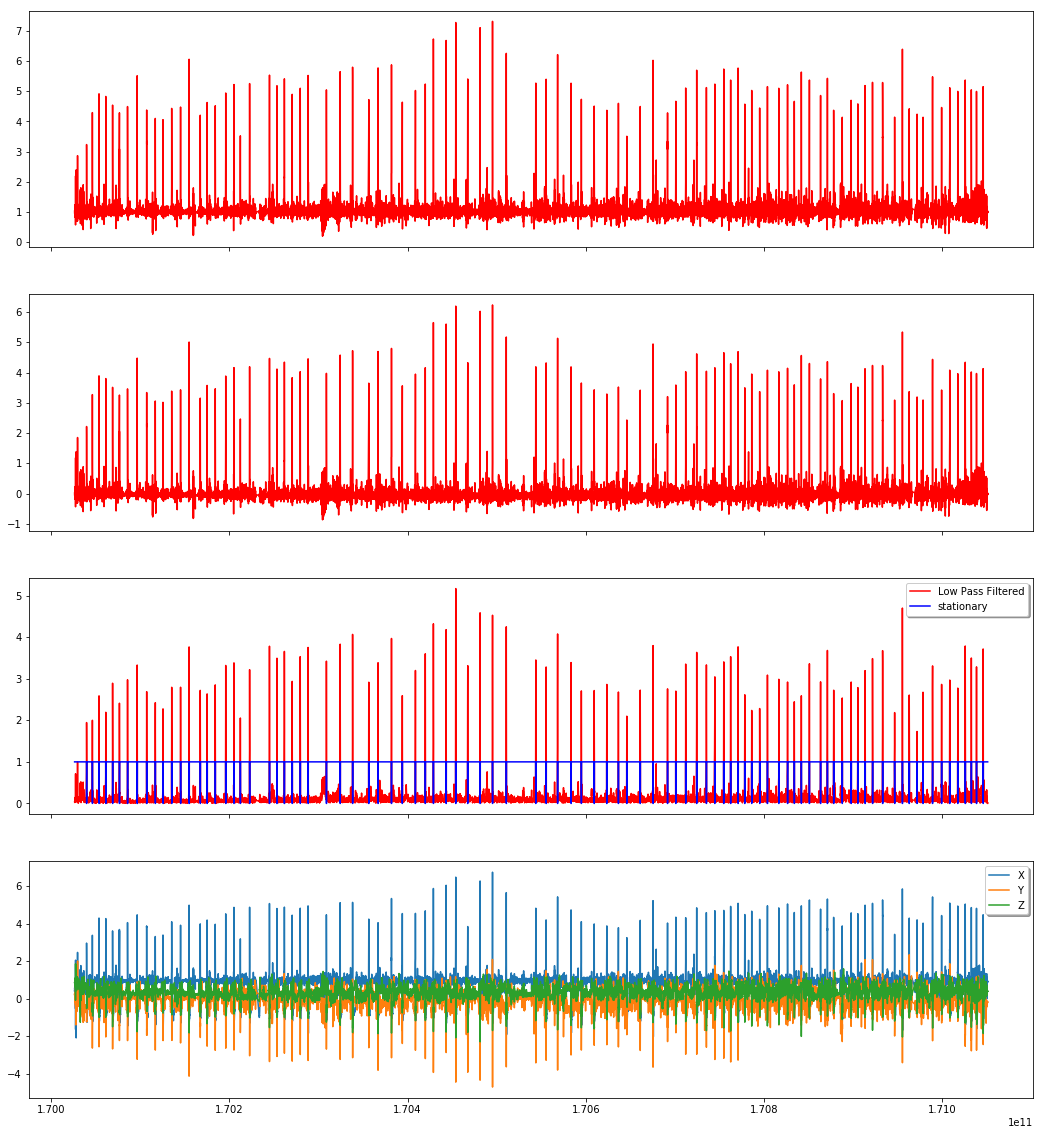

In [25]:

### this can help us detect the stroke itself.
## need to meet a professor from Electrical Department, who can help us understand this part

#HP filter accelerometer data

filtCutOff = .001;
sampleFrequecy = 50;
number_of_pass = 1
acc_mag = np.sqrt(np.square(test_acc).sum(axis=1))

b, a =  signal.butter(number_of_pass, (2*filtCutOff) / sampleFrequecy, 'high', analog=False)
acc_magFilt = signal.filtfilt(b, a, acc_mag)

f, (ax4, ax1, ax2, ax3) = plt.subplots(4, sharex=True, figsize=(18,20))
ax4.plot(sample_time, acc_mag, 'r', label="Magnitude");

ax1.plot(sample_time, acc_magFilt, 'r', label="High Pass Filtered");

# Compute absolute value
acc_magFilt = np.absolute(acc_magFilt);

# LP filter accelerometer data
filtCutOff = 5.0;
b, a = signal.butter(number_of_pass, (2*(filtCutOff)/ (sampleFrequecy)), 'low')
acc_magFilt = signal.filtfilt(b, a, acc_magFilt)


stationary = acc_magFilt < 1;

ax2.plot(sample_time, acc_magFilt, 'r', label="Low Pass Filtered");
ax2.plot(sample_time, stationary, 'b', label="stationary");

#stationary = acc_magFilt < 0.5; ### this can help us detect the 
ax2.legend(shadow=True, fancybox=True, loc="upper right");



ax3.plot(sample_time, test_acc);

ax3.legend(['X','Y','Z'],shadow=True, fancybox=True, loc="upper right");







IndexError: index 96 is out of bounds for axis 0 with size 96

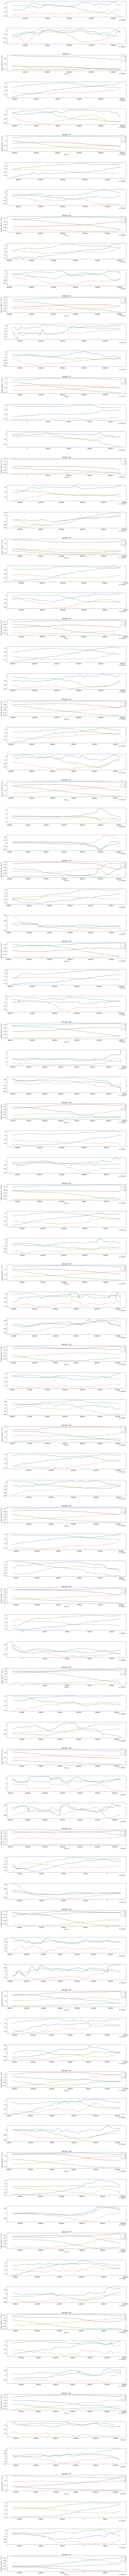

In [40]:
sample_index = np.where(model_prediction==1)[0]
sample_size = len(sample_index)
f, axes = plt.subplots(sample_size,  figsize=(18,400))
f.subplots_adjust(hspace=.7)
backhand = np.squeeze(swing_test, axis=(3,))
i = 0;
for index in sample_index: 
    si = index
    axes[i].plot()
    axes[i].plot(test_time[index*50: (index*50)+50],backhand[index,0:3].T )
    i += 1
    axes[i].plot(test_time[index*50: (index*50)+50],backhand[index, 3:6].T )
    i += 1
    axes[i].plot(test_time[index*50: (index*50)+50],backhand[index, 6:10].T )
    axes[i].set_title('Swing #  %d' % index);
    axes[i].set_xlabel('Time (s)');
    axes[i].set_ylabel('Angular velocity (^\circ/s)');
    axes[i].legend(['X', 'Y', 'Z'],shadow=True, fancybox=True, loc="upper right");
    i += 1